In this notebook, I will be finetuning the RESNET50 model (pretrained on the IMAGENET dataset) for classifying the CIFAR 10 images.

**Note**: Extracting the images from the 7z files is time consuming, especially for the images in the test set. In a separate [notebook](https://www.kaggle.com/code/syerramilli/cifar10-extract-images-as-numpy-arrays), I extracted the images into compressed `.npz` formats. I will be using this format instead.

In [1]:
import os
import re
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder

from pathlib import Path
from typing import Dict,Optional, List, Tuple

plt.style.use('ggplot')

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
images_folder = Path('/kaggle/input/cifar10-extract-images-as-numpy-arrays/')
input_folder = Path('/kaggle/input/cifar-10')

IMG_HEIGHT = 32
IMG_WIDTH = 32
N_CLASSES = 10
BATCH_SIZE = 64
EPOCHS = 4

## Load training data and create label encoder

In [3]:
# load labels
labels_dat = pd.read_csv(input_folder/'trainLabels.csv',index_col=['id']).iloc[:,0]

# build encoder from labels
label_encoder = LabelEncoder().fit(labels_dat)
classes = label_encoder.classes_
print('Classes in CIFAR10')
print(classes)

Classes in CIFAR10
['airplane' 'automobile' 'bird' 'cat' 'deer' 'dog' 'frog' 'horse' 'ship'
 'truck']


In [4]:
def load_data_from_npz(filepath:Path) -> Tuple[np.ndarray]:
    npz_out = np.load(filepath)
    return npz_out['images'],npz_out['ids']

In [5]:
# load images 
images, ids = load_data_from_npz(images_folder/'train.npz')

# get corresponding labels
labels = label_encoder.transform(labels_dat.loc[ids])

## Visualization utitities

In [6]:
def display_images(images:np.ndarray, labels:np.ndarray, title:str,seed:Optional[int]=None):

    n = 10
    
    if seed is not None:
        np.random.seed(seed)
    idxs_to_show = np.random.choice(len(labels), size=n)
    
    imgs_show = images[idxs_to_show,...]
    labels_show = labels[idxs_to_show]

    fig = plt.figure(figsize=(20, 4))
    plt.title(title)
    plt.yticks([])
    plt.xticks([])
    
    for i in range(10):
        ax = fig.add_subplot(1, 10, i+1)
        plt.xlabel(classes[labels_show[i]])
        plt.xticks([])
        plt.yticks([])
        plt.imshow(imgs_show[i])
        
    return fig

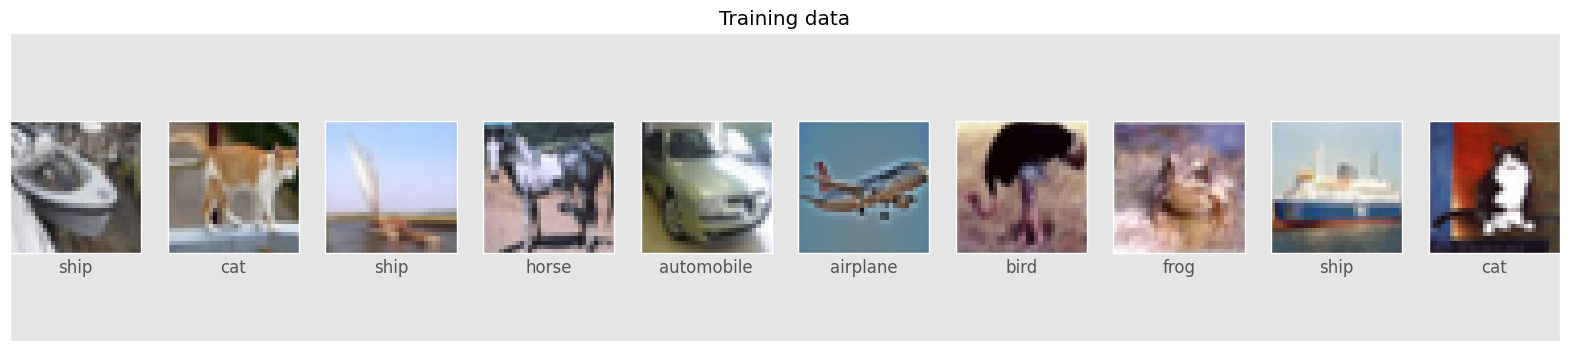

In [7]:
_ = display_images(images,labels,'Training data',seed=1)

## Preprocess images

In [8]:
def preprocess_images(images:np.ndarray) -> np.ndarray:
    images = images.astype(np.float32)
    return tf.keras.applications.resnet50.preprocess_input(images)

X = preprocess_images(images)

##  Architecture

I will be performing transfer learning on the ResNet50 model available in Keras. 
- I will load the pretrained imagenet weights to the model
- I will discard the final classification layer and train one from scratch.
- The resnet model was trained on images of size 224x224 while the CIFAR images are 32x32. I will be using an Upsampling layer to handle this discrepancy.  

I will be using the functional API in Keras to build the model.

In [9]:
def classifier_module(inputs):
    '''
    Defines the final dense layers followed by the softmax layer for classification
    '''
    x = tf.keras.layers.GlobalAveragePooling2D()(inputs)
    x = tf.keras.layers.Dense(1024, activation="relu")(x)
    x = tf.keras.layers.Dense(512, activation="relu")(x)
    x = tf.keras.layers.Dense(N_CLASSES, activation="softmax", name="classification")(x)
    return x

def construct_model() -> tf.keras.Model:
    '''
    Builds a resnet50 based classification model with the specified hyperparameters
        
    Returns
    -----------
    model: tf.keras.Model
        A compliled keras model
    '''
    
    inputs = tf.keras.Input(shape=(IMG_WIDTH,IMG_HEIGHT,3))
    resize = tf.keras.layers.UpSampling2D(size=(7,7))(inputs)
    
    resnet_features = tf.keras.applications.resnet.ResNet50(
        input_shape=(224,224,3),
        include_top=False,
        weights='imagenet'
    )(resize)
    
    classification_output = classifier_module(resnet_features)
    
    model = tf.keras.Model(inputs=inputs,outputs=classification_output)
    
    # compile
    model.compile(
        optimizer=tf.keras.optimizers.SGD(),
        loss = 'sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

In [10]:
# build model
tf.keras.backend.clear_session()        
model = construct_model()
print(model.summary())

94765736/94765736 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 up_sampling2d (UpSampling2D  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 1024)              2098176   
                                                              

## Train model

In [11]:
#further divide into train and validation splits for early stopping
# stratified on the labels
X_train,X_val,y_train,y_val = train_test_split(
    X,labels,test_size=0.1,random_state=1,
    stratify = labels
)

# train model
history = model.fit(
    X_train,
    y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(X_val, y_val),
    verbose=True
)

Epoch 1/4
704/704 [==============================] - 255s 333ms/step - loss: 0.4272 - accuracy: 0.8600 - val_loss: 0.4850 - val_accuracy: 0.8364
Epoch 2/4
704/704 [==============================] - 233s 330ms/step - loss: 0.1084 - accuracy: 0.9646 - val_loss: 0.2765 - val_accuracy: 0.9122
Epoch 3/4
704/704 [==============================] - 232s 330ms/step - loss: 0.0380 - accuracy: 0.9888 - val_loss: 0.1632 - val_accuracy: 0.9474
Epoch 4/4
704/704 [==============================] - 232s 330ms/step - loss: 0.0153 - accuracy: 0.9968 - val_loss: 0.1712 - val_accuracy: 0.9512


In [12]:
# save model
model.save_weights(f'cifar10_resnet_{EPOCHS}-epochs.h5')

## Test predictions

In [13]:
# load the test set images
test_images, test_ids = load_data_from_npz(images_folder/'test.npz')

In [14]:
%%time 
from tqdm import tqdm

# get prediction probabilities
# using for loop to prevent out-of-memory issues when using predict
TEST_BATCH_SIZE=1000
batch_vectors= []

for i in tqdm(range(0,test_images.shape[0],TEST_BATCH_SIZE)):
    #print(f" Processing Batch {i//TEST_BATCH_SIZE + 1}")
    batch_X = preprocess_images(test_images[i:i+TEST_BATCH_SIZE,...])
    batch_vectors.append(
        model.predict(batch_X, verbose=False,batch_size=TEST_BATCH_SIZE)
    )
    
test_pred_probs = np.concatenate(batch_vectors)

100%|██████████| 300/300 [06:52<00:00,  1.38s/it]

CPU times: user 6min 51s, sys: 1.79 s, total: 6min 53s
Wall time: 6min 52s


In [15]:
# get prediction labels 
test_preds = test_pred_probs.argmax(axis=1)

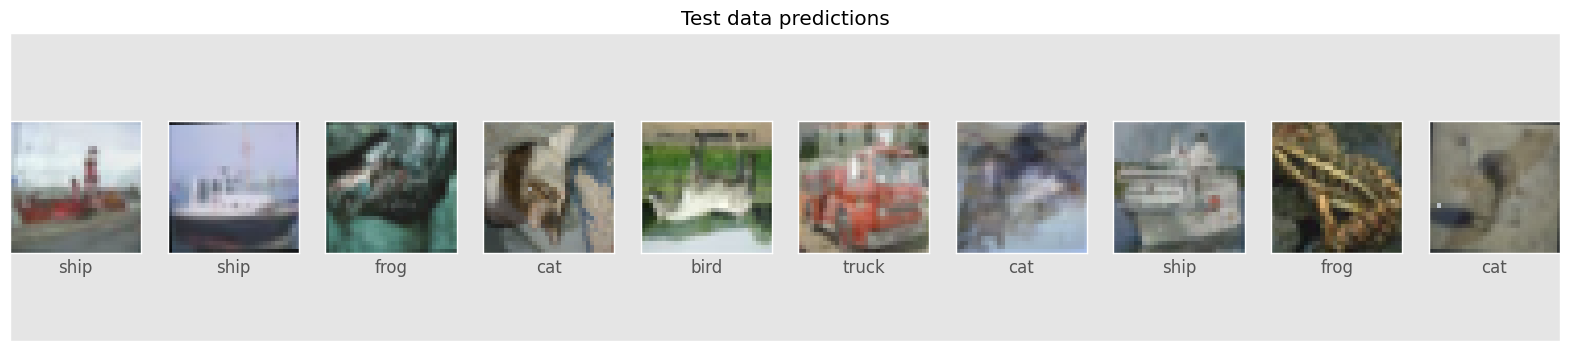

In [16]:
# visualizaing some of the test set predictions
_ = display_images(test_images,test_preds,'Test data predictions',seed=0)

In [ ]:
# creating submission file
submission = pd.DataFrame({
    'id': test_ids,
    'label':label_encoder.inverse_transform(test_preds)
})
submission.to_csv('submission.csv',index=False)